# Gerekli Kütüphaneleri Import Ediyorum

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from seaborn import histplot

from sklearn.metrics import f1_score, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torchvision import transforms
from torch.utils.data import Dataset, TensorDataset, DataLoader

import os
from PIL import Image

## Directions
Directionları giriyorum. İlk başlarda dataseti import ederken hata aldığım için izinleri kontrol ediyorum.  
2. train_dir'in sebebi kodu daha hızlı çalıştırmak ve bug fix aşamasını daha hızlı yapmak için dataseti ayırmam. orijinal olan dataset 'original' klasörü altında.

In [2]:
train_dir = os.path.join(os.getcwd(), 'brain-tumor')
train_dir = os.path.join(train_dir, 'train')
#train_dir = os.path.join(train_dir, 'original')
images_dir = os.path.join(train_dir, 'images')
labels_dir = os.path.join(train_dir, 'labels')
print(os.access(images_dir, os.R_OK))  # Check read permission
print(os.access(images_dir, os.W_OK))  # Check write permission
print(os.access(images_dir, os.X_OK))  # Check execute permission

True
True
True


## Karşılıksız Dosyaları Silme

In [3]:
labels = set(file.split('.')[0] for file in os.listdir(labels_dir))
images = set(file.split('.')[0] for file in os.listdir(images_dir))

for file in images - labels:
    os.remove(os.path.join(images_dir, file + '.jpg'))

# Dataset import class'ı
image'lerin hepsi jpg ile bittiği için diğer uzantıları eklemedim.  

getitem'da image'leri siyah-beyaz olarak istedim. Label'larda ise ilk değeri aldım. batch için unsqueeze ile ekstra dimension ekledim. ileride squeeze kullanacağım. Örnek olarak:  
> label = 1
> 1. int(1) -> 1
> 2. torch.tensor(1, dtype=torch.float32) -> tensor(1.0)
> 3. tensor(1.0).unsqueeze(0) -> tensor([1.0]) (shape (1,))

Olası hata durumlarını ayıklamak için try except ile düzeltmelerimi yaptım. Başta dediğim gibi directionlardan kaynaklanan sorunlar aldım, izinleri kontrol etmek işe yaradı.

In [4]:
class BrainTumorDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform = None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        
        self.image_filenames = sorted([os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.lower().endswith(('.jpg'))])
    def __len__(self):
        return len(self.image_filenames)
    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.images_dir, img_name + '.jpg')
        label_path = os.path.join(self.labels_dir, img_name + '.txt')

        try:
            image = Image.open(image_path)
            image = image.convert('L') # ensure black and white
            
            with open(label_path, 'r') as f:
                label = int(f.read().strip()[0])  # Convert '0'/'1' to integer
            label = torch.tensor(int(label), dtype=torch.float32).unsqueeze(0)


            if self.transform:
                image = self.transform(image)

            return image, label
        except FileNotFoundError:
            print(f"Warning: Image or label file not found for {img_name}. Skipping.")
            return self.__getitem__((idx + 1) % len(self)) # Return the next item (handles edge cases)
        except Exception as e: # Catch other potential issues
            print(f"Error loading image or label for {img_name}: {e}. Skipping.")
            return self.__getitem__((idx + 1) % len(self)) # Return the next item (handles edge cases)


## Load Dataset
Transformation'ları tanımladm.  
Batch ayarlarını yaptım ve train_loader ile uygun hale getirdim.  

In [5]:
# Define transformations
data_transforms = transforms.Compose([
    transforms.Resize((512, 512)),  # Ensure correct size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])

dataset = BrainTumorDataset(images_dir, labels_dir, transform=data_transforms)

batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Accessing data:
for i in range(len(dataset)):
    image, label = dataset[i]
    print(f"Image shape: {image.shape}, Label: {label}")

Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), Label: tensor([1.])
Image shape: torch.Size([1, 512, 512]), 

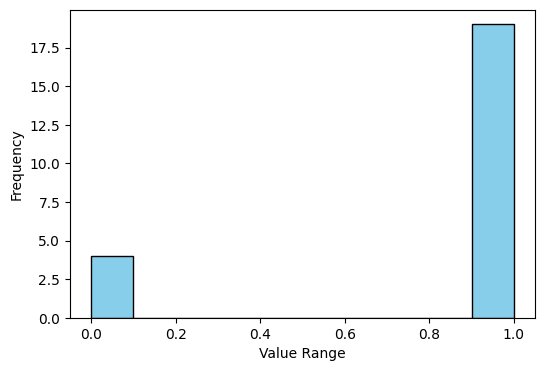

In [6]:
_labels_np = torch.tensor([label for _, label in dataset]).numpy()
plt.figure(figsize=(6, 4))

# Histogram visualization to see frequency distribution
plt.hist(_labels_np, bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Value Range")
plt.ylabel("Frequency")

# Show plot
plt.show()

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self): # Will not add in channels parameter, assuming black and white which only has 1 channel
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))

        # 16 out channels, 128x128 remaining res.
        self.fc1 = nn.Linear(16 * 128 * 128, 128)  
        self.fc2 = nn.Linear(128, 1)  # Output layer for binary classification
        
    def forward(self, x):
        x = nn.ReLU()(self.conv1(x)) # First step
        x = self.pool(x)
        
        x = nn.ReLU()(self.conv2(x)) # Second step
        x = self.pool(x)
        
        x = x.view(-1, 16 * 128 * 128)  # Flatten
        # safer alternatives:
        # x = x.view(x.shape[0], -1)
        # x = x.reshape(x.shape[0], -1)
        
        x = nn.ReLU()(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

In [8]:
model = SimpleCNN()

In [9]:
# Cross-Entropy Loss Function
criterion  = nn.BCEWithLogitsLoss()

In [10]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### num_epochs
num_epochs'u farklı farklı sayılarda denememe rağmen her zaman ilk değere eşit geldi. O yüzden 1 yapacaktım fakat farklılık olma ihtimaline karşılık gözlemliyim diye 2 yapıyorum.

In [11]:
num_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
for epoch in range(num_epochs):
    model.train()
    for images, labels in dataset:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).squeeze(1)  # Forward pass
        labels = labels.view(-1)  # Ensure labels have shape [batch_size]
        loss = criterion(outputs, labels)  # Compute loss
        
        optimizer.zero_grad()   # Clear previous gradients
        loss.backward()  # Backpropagation (compute gradients)
        
        optimizer.step()  # Update weights
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/2], Loss: 1.3133
Epoch [2/2], Loss: 1.3133


In [12]:
def binary_classification_metrics(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to compute gradients for evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Get predictions from CNN
            outputs = model(images)  # Forward pass through the CNN

            # Apply sigmoid to logits and threshold to get binary predictions
            probs = torch.sigmoid(outputs).squeeze()  # Apply sigmoid to get probabilities
            preds = (probs > 0.5).float()  # Thresholding at 0.5 for binary classification

            all_preds.extend(preds.cpu().numpy())  # Move to CPU and append to list
            all_labels.extend(labels.cpu().numpy())  # Same for labels

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, f1
accuracy, f1 = binary_classification_metrics(model, dataset, device)
print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

TypeError: iteration over a 0-d array